# **Waze: Churn Prediction**

## **Pace: Plan **

### **Step 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

### Step 2: Data Exploration (Initial EDA and data cleaning)
Understand variables
Clean your dataset (missing data, redundant data, outliers)

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspect the first five rows
### YOUR CODE HERE ###
df0.head(5)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [4]:
df = df0.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


1. Column "lable" shows missing (or NULL) values.
2. There are 14,998 rows and 13 columns. Amoung which 3 columns of floats64, 8 of int64, and 2 objects (label and device) datatypes.
3. There are only 14,299 labeled rows. Meaning 700 rows don't have any label.

### **Null values and summary statistics**

Compare the summary statistics of the 700 rows that are missing labels with summary statistics of the rows that are not missing any values.

**Question:** Is there a significant difference between the two populations?


In [5]:
# Isolate rows with null values
null_df = df[df['label'].isnull()]

# Display summary stats of rows with null values
null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [6]:
# Isolate rows without null values
not_null_df = df[~df['label'].isnull()]

# Display summary stats of rows without null values
not_null_df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


When comparing the summary statistics of observations with missing retention labels to those without any missing values, no significant differences are observed. The means and standard deviations show a reasonable degree of consistency between the two groups.

### **Null values - device counts**

Next, check the two populations with respect to the `device` variable.

**Question:** How many iPhone users had null values and how many Android users had null values?

In [7]:
# Get count of null values by device
null_df['device'].value_counts()

iPhone     447
Android    253
Name: device, dtype: int64

In [8]:
# Calculate % of iPhone nulls and Android nulls
null_df['device'].value_counts(normalize=True)*100

iPhone     63.857143
Android    36.142857
Name: device, dtype: float64

Out of 700 users without label 36%(i.e. 253) are Android users and rest 64% (i.e. 477) are iPhone users.

In [9]:
# Calculate % of iPhone users and Android users in full dataset
df['device'].value_counts(normalize=True)

iPhone     0.644843
Android    0.355157
Name: device, dtype: float64

The percentage of missing values by each device is consistent with their representation in the data overall.
There is nothing to suggest a non-random cause of the missing data.

**Examine the counts and percentages of users who churned vs. those who were retained. How many of each group are represented in the data?**

In [10]:
# Calculate counts of churned vs. retained
print(df['label'].value_counts())
print("-"*10)
print(df['label'].value_counts(normalize=True))

retained    11763
churned      2536
Name: label, dtype: int64
----------
retained    0.822645
churned     0.177355
Name: label, dtype: float64


This dataset contains 82% retained users and 18% churned users.

Next, compare the medians of each variable for churned and retained users. The reason for calculating the median and not the mean is that you don't want outliers to unduly affect the portrayal of a typical user. Notice, for example, that the maximum value in the `driven_km_drives` column is 21,183 km. That's more than half the circumference of the earth!

In [11]:
# Calculate median values of all columns for churned and retained users
df.groupby('label').median()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


This offers an interesting snapshot of the two groups, churned vs. retained:

Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period.

The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user.

It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile. Continue exploring!

**Calculate the median kilometers per drive in the last month for both retained and churned users.**

In [12]:
# Group data by `label` and calculate the medians
median_by_label_df = df.groupby('label').median()
print('Median kilometers per drive:')
# Divide the median distance by median number of drives
median_by_label_df['driven_km_drives'] / median_by_label_df['drives']

Median kilometers per drive:


label
churned     73.053113
retained    73.716694
dtype: float64

The median user from both groups drove ~73 km/drive. How many kilometers per driving day was this?

In [13]:
# Divide the median distance by median number of driving days
print('Median kilometers per driving day:')
median_by_label_df['driven_km_drives'] / median_by_label_df['driving_days']

Median kilometers per driving day:


label
churned     608.775944
retained    247.477472
dtype: float64

Now, calculate the median number of drives per driving day for each group.

In [14]:
# Divide the median number of drives by median number of driving days
print('Median drives per driving day:')
median_by_label_df['drives'] / median_by_label_df['driving_days']


Median drives per driving day:


label
churned     8.333333
retained    3.357143
dtype: float64

The median user who churned drove 608 kilometers each day they drove last month, which is almost 250% the per-drive-day distance of retained users. The median churned user had a similarly disproporionate number of drives per drive day compared to retained users.

It is clear from these figures that, regardless of whether a user churned or not, the users represented in this data are serious drivers! It would probably be safe to assume that this data does not represent typical drivers at large. Perhaps the data&mdash;and in particular the sample of churned users&mdash;contains a high proportion of long-haul truckers.

In consideration of how much these users drive, it would be worthwhile to recommend to Waze that they gather more data on these super-drivers. It's possible that the reason for their driving so much is also the reason why the Waze app does not meet their specific set of needs, which may differ from the needs of a more typical driver, such as a commuter.

Finally, examine whether there is an imbalance in how many users churned by device type.

Begin by getting the overall counts of each device type for each group, churned and retained.

In [15]:
# For each label, calculate the number of Android users and iPhone users
churn_by_device_count = df.groupby(['label', 'device']).size().unstack(fill_value=0)
churn_by_device_count

device,Android,iPhone
label,,
churned,891,1645
retained,4183,7580


Now, within each group, churned and retained, calculate what percent was Android and what percent was iPhone.

In [16]:
# For each label, calculate the percentage of Android users and iPhone users
percent_churn_by_device_count = churn_by_device_count.div(churn_by_device_count.sum(axis=1), axis=0)
percent_churn_by_device_count

device,Android,iPhone
label,,
churned,0.351341,0.648659
retained,0.355607,0.644393


The ratio of iPhone users and Android users is consistent between the churned group and the retained group, and those ratios are both consistent with the ratio found in the overall dataset.

💭
### Reflect on these questions to complete the plan stage:
**1. Did the data contain any missing values? How many, and which variables were affected? Was there a pattern to the missing data?**
   - Labels were missing for 700 entries. Nothing seem to indicate a pattern with missing entries.


**2. What is a benefit of using the median value of a sample instead of the mean?**
   - It prevents outliers to skew the representation of a typical user.


**3. What percentage of the users in the dataset were Android users and what percentage were iPhone users?**
  - 64.48% of users are user of iPhones while 35.52% of users are using Android.


**4. What were some distinguishing characteristics of users who churned vs. users who were retained?**
  - The median user who churned drove 608 kilometers each day they drove last month, which is nearly 250% more than the per-drive-day distance of retained users. Additionally, the median churned user had a similarly disproportionate number of drives per drive day compared to retained users.


**5. Was there an appreciable difference in churn rate between iPhone users vs. Android users?**
  - No, there doesn't appear to be an appreciable difference in churn rate between iPhone users and Android users. The ratio of iPhone users to Android users is consistent within both the churned and retained groups, and these ratios align with the overall dataset. This suggests that the type of device used (iPhone or Android) doesn't significantly influence churn rate in this dataset.

## pAce: Analyze Stage
Perform EDA (analyze relationships between variables)

### Step 2. Data Exploration (Continue EDA)

- Outliers are often defined as data points that fall significantly outside the expected range based on these statistics
- Box plots provide a visual representation of the distribution of data and highlight outliers as individual data points beyond the "whiskers" of the box. They are particularly useful for detecting univariate outliers. 
- Calculate the IQR, which is the range between the 25th percentile (Q1) and the 75th percentile (Q3). 
- Data points beyond **Q1 - 1.5 * IQR** or **Q3 + 1.5 * IQR** are considered outliers.

#### **`sessions`**

_The number of occurrence of a user opening the app during the month_

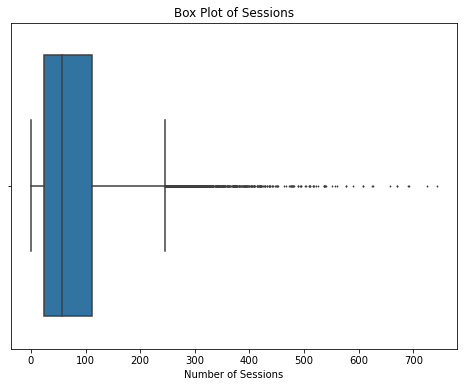

In [17]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['sessions'], fliersize=1)
plt.title('Box Plot of Sessions')
plt.xlabel('Number of Sessions')
plt.show()

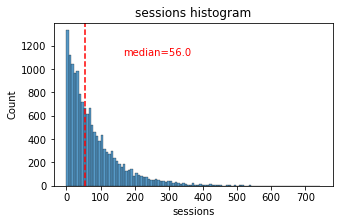

In [18]:
# Histogram
def histogrammer(column_str, median_text=True, **kwargs):    # **kwargs = any keyword arguments
                                                             # from the sns.histplot() function
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df[column_str], **kwargs)            # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')         # Plot the median line
    if median_text==True:                                    # Add median text unless set to False
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

histogrammer('sessions')

The `sessions` variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.

#### **`drives`**

_An occurrence of driving at least 1 km during the month_

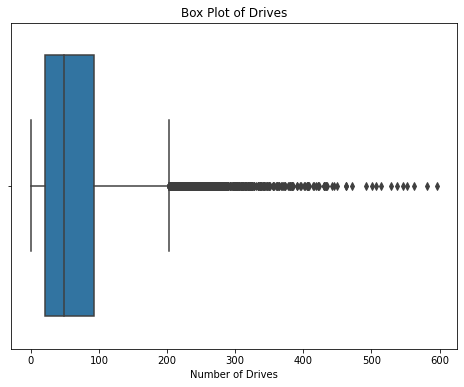

In [19]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='drives')
plt.title('Box Plot of Drives')
plt.xlabel('Number of Drives')
plt.show()

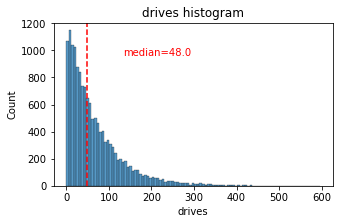

In [20]:
# Histogram
histogrammer('drives')

The `drives` information follows a distribution similar to the `sessions` variable. It is right-skewed, approximately log-normal, with a median of 48. However, some drivers had over 400 drives in the last month.

#### **`total_sessions`**

_A model estimate of the total number of sessions since a user has onboarded_

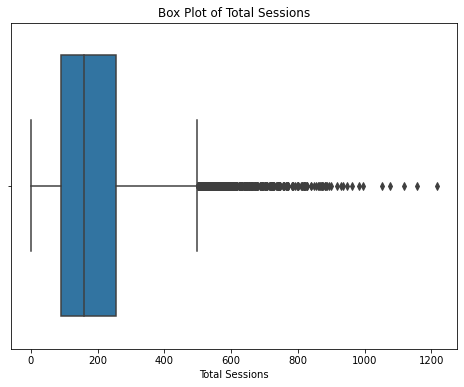

In [21]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='total_sessions')
plt.title('Box Plot of Total Sessions')
plt.xlabel('Total Sessions')
plt.show()

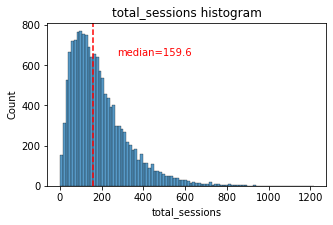

In [22]:
# Histogram
histogrammer('total_sessions')

The `total_sessions` is a right-skewed distribution. The median total number of sessions is 159.6. This is interesting information because, if the median number of sessions in the last month was 48 and the median total sessions was ~160, then it seems that a large proportion of a user's total drives might have taken place in the last month. This is something you can examine more closely later.

#### **`n_days_after_onboarding`**

_The number of days since a user signed up for the app_

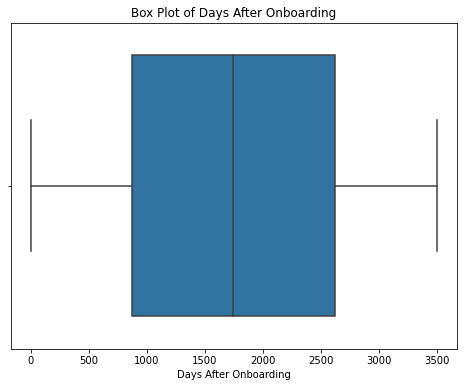

In [23]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='n_days_after_onboarding')
plt.title('Box Plot of Days After Onboarding')
plt.xlabel('Days After Onboarding')
plt.show()

Median: 1741.0


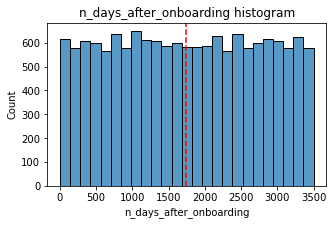

In [24]:
# Histogram
histogrammer('n_days_after_onboarding', median_text=False)

The total user tenure (i.e., number of days since
onboarding) is a uniform distribution with values ranging from near-zero to \~3,500 (\~9.5 years).

#### **`driven_km_drives`**

_Total kilometers driven during the month_

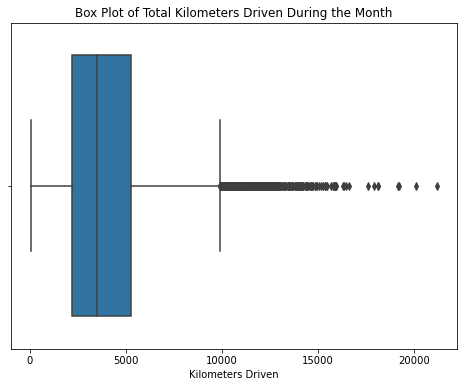

In [25]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='driven_km_drives')
plt.title('Box Plot of Total Kilometers Driven During the Month')
plt.xlabel('Kilometers Driven')
plt.show()

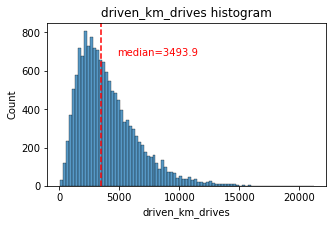

In [26]:
# Histogram
histogrammer('driven_km_drives')

The number of drives driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers. As you discovered in the analysis from the previous course, the users in this dataset drive _a lot_. The longest distance driven in the month was over half the circumferene of the earth.

#### **`duration_minutes_drives`**

_Total duration driven in minutes during the month_

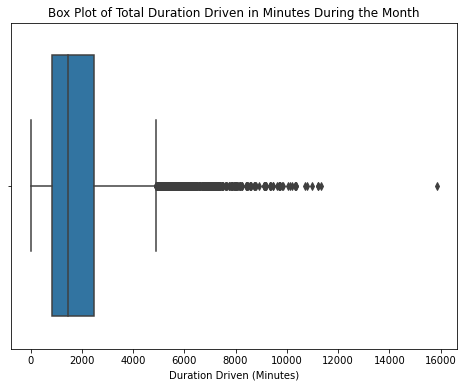

In [27]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='duration_minutes_drives')
plt.title('Box Plot of Total Duration Driven in Minutes During the Month')
plt.xlabel('Duration Driven (Minutes)')
plt.show()

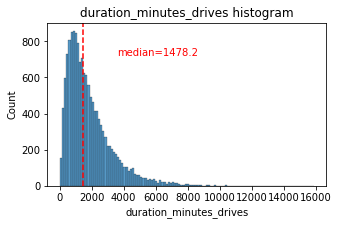

In [28]:
# Histogram
histogrammer('duration_minutes_drives')

The `duration_minutes_drives` variable has a heavily skewed right tail. Half of the users drove less than \~1,478 minutes (\~25 hours), but some users clocked over 250 hours over the month.

#### **`activity_days`**

_Number of days the user opens the app during the month_

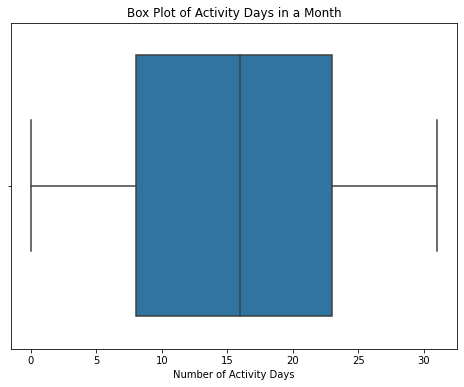

In [29]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='activity_days')
plt.title('Box Plot of Activity Days in a Month')
plt.xlabel('Number of Activity Days')
plt.show()

Median: 16.0


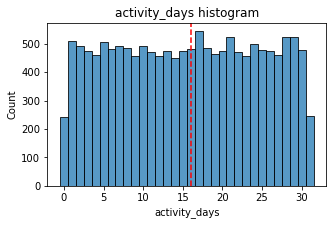

In [30]:
# Histogram
histogrammer('activity_days', median_text=False, discrete=True)

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month.

This distribution is noteworthy because it does not mirror the `sessions` distribution, which you might think would be closely correlated with `activity_days`.

#### **`driving_days`**

_Number of days the user drives (at least 1 km) during the month_

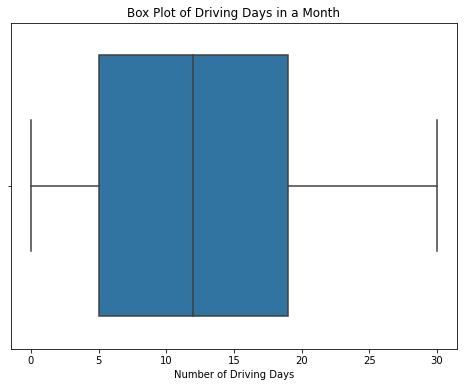

In [31]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='driving_days')
plt.title('Box Plot of Driving Days in a Month')
plt.xlabel('Number of Driving Days')
plt.show()

Median: 12.0


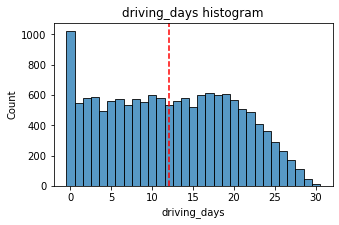

In [32]:
# Histogram
histogrammer('driving_days', median_text=False, discrete=True)

The number of days users drove each month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the `driving_days` distribution tails off on the right.

However, there were almost twice as many users (\~1,000 vs. \~550) who did not drive at all during the month. This might seem counterintuitive when considered together with the information from `activity_days`. That variable had \~500 users opening the app on each of most of the day counts, but there were only \~250 users who did not open the app at all during the month and ~250 users who opened the app every day. Flag this for further investigation later.

#### **`device`**

_The type of device a user starts a session with_

This is a categorical variable, so you do not plot a box plot for it. A good plot for a binary categorical variable is a pie chart.

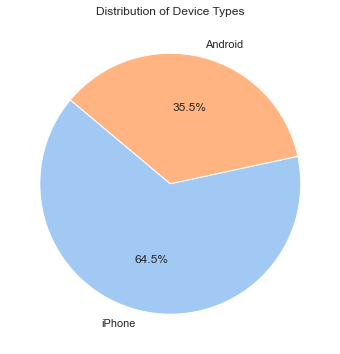

In [33]:
# Pie chart
device_counts = df['device'].value_counts()
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Device Types')
plt.show()

There are nearly twice as many iPhone users as Android users represented in this data.

#### **`label`**

_Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month_

This is also a categorical variable, and as such would not be plotted as a box plot. Plot a pie chart instead.

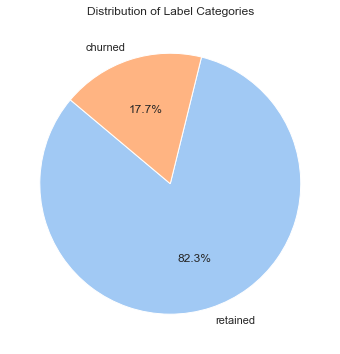

In [34]:
# Pie chart
label_counts = df['label'].value_counts()
plt.figure(figsize=(6, 6))
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Label Categories')
plt.show()

Less than 18% of the users churned.

#### **`driving_days` vs. `activity_days`**

Because both `driving_days` and `activity_days` represent counts of days over a month and they're also closely related, you can plot them together on a single histogram. This will help to better understand how they relate to each other without having to scroll back and forth comparing histograms in two different places.

Plot a histogram that, for each day, has a bar representing the counts of `driving_days` and `activity_days`.

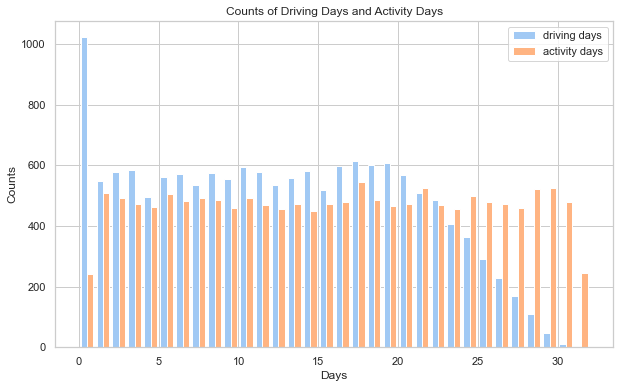

In [35]:
# Histogram
plt.figure(figsize=(10, 6))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('Days')
plt.ylabel('Counts')
plt.title('Counts of Driving Days and Activity Days')
plt.legend()
plt.show()

As observed previously, this might seem counterintuitive. After all, why are there _fewer_ people who didn't use the app at all during the month and _more_ people who didn't drive at all during the month?

On the other hand, it could just be illustrative of the fact that, while these variables are related to each other, they're not the same. People probably just open the app more than they use the app to drive&mdash;perhaps to check drive times or route information, to update settings, or even just by mistake.

Nonetheless, it might be worthwile to contact the data team at Waze to get more information about this, especially because it seems that the number of days in the month is not the same between variables.

Confirm the maximum number of days for each variable&mdash;`driving_days` and `activity_days`.

In [36]:
max_driving_days = df['driving_days'].max()
max_activity_days = df['activity_days'].max()

print("Maximum Driving Days:", max_driving_days)
print("Maximum Activity Days:", max_activity_days)

Maximum Driving Days: 30
Maximum Activity Days: 31


It's true. Although it's possible that not a single user drove all 31 days of the month, it's highly unlikely, considering there are 15,000 people represented in the dataset.

One other way to check the validity of these variables is to plot a simple scatter plot with the x-axis representing one variable and the y-axis representing the other.

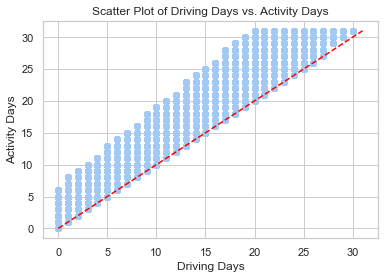

In [37]:
# Scatter plot
plt.scatter(df['driving_days'], df['activity_days'])
plt.title('Scatter Plot of Driving Days vs. Activity Days')
plt.xlabel('Driving Days')
plt.ylabel('Activity Days')
plt.plot([0,31], [0,31], color='red', linestyle='--');
plt.show()

Notice that there is a theoretical limit. If you use the app to drive, then by definition it must count as a day-use as well. In other words, you cannot have more drive-days than activity-days. None of the samples in this data violate this rule, which is good.

#### **Retention by device**

Plot a histogram that has four bars&mdash;one for each device-label combination&mdash;to show how many iPhone users were retained/churned and how many Android users were retained/churned.

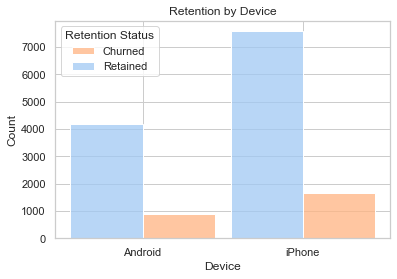

In [38]:
# Histogram
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Retention by Device')
plt.legend(title='Retention Status', labels=['Churned', 'Retained'])

# Show the plot
plt.show()

The proportion of churned users to retained users is consistent between device types.

#### **Retention by kilometers driven per driving day**

In the previous course, you discovered that the median distance driven last month for users who churned was 8.33 km, versus 3.36 km for people who did not churn. Examine this further.

1. Create a new column in `df` called `km_per_driving_day`, which represents the mean distance driven per driving day for each user.

2. Call the `describe()` method on the new column.

In [39]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']


# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

**What do you notice? The mean value is infinity, the standard deviation is NaN, and the max value is infinity. Why do you think this is?**

- This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

  - 1. Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.
  - 2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [40]:
# 1. Convert infinite values to zero
df['km_per_driving_day'] = df['km_per_driving_day'].replace([np.inf, -np.inf], 0)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

The maximum value is 15,420 kilometers _per drive day_. This is physically impossible. Driving 100 km/hour for 12 hours is 1,200 km. It's unlikely many people averaged more than this each day they drove, so, for now, disregard rows where the distance in this column is greater than 1,200 km.

Plot a histogram of the new `km_per_driving_day` column, disregarding those users with values greater than 1,200 km. Each bar should be the same length and have two colors, one color representing the percent of the users in that bar that churned and the other representing the percent that were retained. This can be done by setting the `multiple` parameter of seaborn's [`histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function to `fill`.

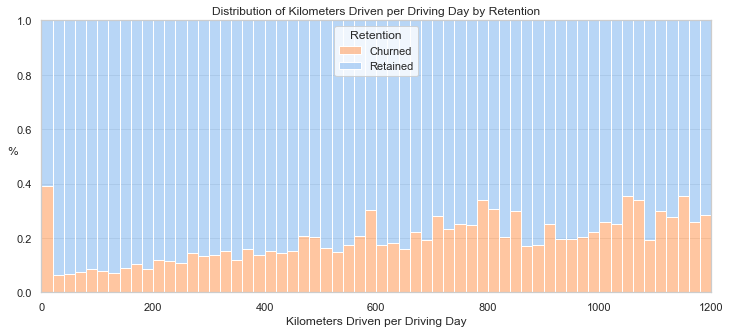

In [41]:
# Histogram
plt.figure(figsize=(12,5))
sns.histplot(data=df, x='km_per_driving_day', bins=range(0,1201,20), hue='label', multiple='fill')
plt.xlabel('Kilometers Driven per Driving Day')
plt.ylabel('%', rotation=0)
plt.title('Distribution of Kilometers Driven per Driving Day by Retention')
plt.legend(title='Retention', labels=['Churned', 'Retained'])
plt.show()

The churn rate tends to increase as the mean daily distance driven increases, confirming what was found in the previous course. It would be worth investigating further the reasons for long-distance users to discontinue using the app.

#### **Churn rate per number of driving days**

Create another histogram just like the previous one, only this time it should represent the churn rate for each number of driving days.

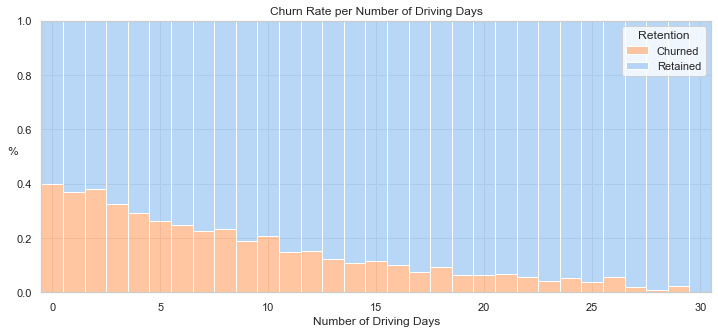

In [42]:
plt.figure(figsize=(12,5))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.xlabel('Number of Driving Days')
plt.title('Churn Rate per Number of Driving Days')
plt.legend(title='Retention', labels=['Churned', 'Retained'])
plt.show()

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

#### **Proportion of sessions that occurred in the last month**

Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [43]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

In [44]:
df['percent_sessions_in_last_month'].median()

0.42309702992763176

Now, create a histogram depicting the distribution of values in this new column.

Median: 0.4


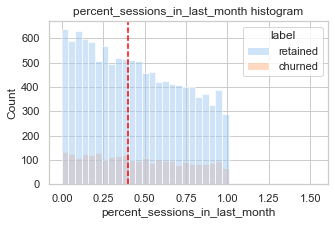

In [45]:
# Histogram
histogrammer('percent_sessions_in_last_month',
             hue=df['label'],
             multiple='layer',
             median_text=False)

Check the median value of the `n_days_after_onboarding` variable.

In [46]:
df['n_days_after_onboarding'].median()

1741.0

Half of the people in the dataset had 40% or more of their sessions in just the last month, yet the overall median time since onboarding is almost five years.

Make a histogram of `n_days_after_onboarding` for just the people who had 40% or more of their total sessions in the last month.

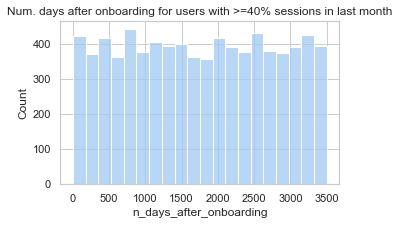

In [47]:
# Histogram
data = df.loc[df['percent_sessions_in_last_month']>=0.4]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=40% sessions in last month');

The number of days since onboarding for users with 40% or more of their total sessions occurring in just the last month is a uniform distribution. This is very strange. It's worth asking Waze why so many long-time users suddenly used the app so much in the last month.

### **Handling outliers**

The box plots from the previous section indicated that many of these variables have outliers. These outliers do not seem to be data entry errors; they are present because of the right-skewed distributions.

Depending on what you'll be doing with this data, it may be useful to impute outlying data with more reasonable values. One way of performing this imputation is to set a threshold based on a percentile of the distribution.

To practice this technique, write a function that calculates the 95th percentile of a given column, then imputes values > the 95th percentile with the value at the 95th percentile.  such as the 95th percentile of the distribution.



In [48]:
def impute_outliers_with_percentile(data, column_name, percentile=95):
    # Calculate the specified percentile for the column
    percentile_value = np.percentile(data[column_name], percentile)

    # Impute values greater than the percentile with the percentile value
    data.loc[data[column_name] > percentile_value, column_name] = percentile_value

Next, apply that function to the following columns:
* `sessions`
* `drives`
* `total_sessions`
* `driven_km_drives`
* `duration_minutes_drives`

In [49]:
for column in ['sessions', 'drives', 'total_sessions', 'driven_km_drives', 'duration_minutes_drives']:
    impute_outliers_with_percentile(df, column, 95)

In [50]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,76.568705,64.058204,184.031320,1749.837789,121.605974,29.672512,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.449255
std,4329.982679,67.297958,55.306924,118.600463,1008.513876,148.121544,45.394651,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.286919
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216
max,14998.000000,243.000000,201.000000,454.363204,3500.000000,1236.000000,415.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.530637


### **Key Insights of EDA**

- Analysis revealed that the overall churn rate is ~17%, and that this rate is consistent between iPhone users and Android users.
- EDA has revealed that users who drive very long distances on their driving days are more likely to churn, but users who drive more often are less likely to churn. The reason for this discrepancy is an opportunity for further investigation, and it would be something else to ask the Waze data team about.

💭
### Reflect on these questions to complete EDA:

**1. What types of distributions notice in the variables? What did this tell about the data?**
- The data revealed various distribution types in the variables, including right-skewed distributions for metrics like sessions, drives, total sessions, and driven kilometers, indicating that a majority of users had relatively lower values in these aspects. On the other hand, metrics such as n_days_after_onboarding exhibited uniform distributions.

**2. Did nvestigation give rise to further questions that would like to explore or ask the Waze team about?**
- Our analysis has generated additional questions. For instance, the sudden increase in app usage during the last month for long-term users seems intriguing and might benefit from further investigation. Understanding the motivations behind this behavior could offer valuable insights.

**3. What percentage of users churned and what percentage were retained?**
- In the dataset, approximately 18% of users churned, while the majority, around 82%, were retained. This percentage provides an overview of the churn situation, but a deeper analysis can help uncover what influences these outcomes.

**4. What factors correlated with user churn? How?**
- Factors like the number of driving days and the percentage of sessions in the last month appear to correlate with churn. Users who drove more and used the app frequently had lower churn rates, which suggests that app engagement and usage play a role in user retention.

### Step 3: Hypothesis testing

**Note:** In the dataset, `device` is a categorical variable with the labels `iPhone` and `Android`.

In order to perform this analysis, you must turn each label into an integer.  The following code assigns a `1` for an `iPhone` user and a `2` for `Android`.  It assigns this label back to the variable `device_new`.

**Note:** Creating a new variable is ideal so that you don't overwrite original data.



In [51]:
# 1. Create `map_dictionary`
device_map = {'iPhone': 1, 'Android': 2}

# 2. Create new `device_type` column
# 3. Map the new column to the dictionary
df['device_type'] = df['device'].map(device_map)

You are interested in the relationship between device type and the number of drives. One approach is to look at the average number of drives for each device type. Calculate these averages.

In [52]:
df.groupby('device_type')['drives'].mean()

device_type
1    64.446340
2    63.353482
Name: drives, dtype: float64

Based on the averages shown, it appears that drivers who use an iPhone device to interact with the application have a higher number of drives on average. However, this difference might arise from random sampling, rather than being a true difference in the number of drives. To assess whether the difference is statistically significant, you can conduct a hypothesis test.

**Conduct a two-sample t-test. Recall the steps for conducting a hypothesis test:**

1.   State the null hypothesis and the alternative hypothesis
2.   Choose a signficance level
3.   Find the p-value
4.   Reject or fail to reject the null hypothesis

**Note:** This is a t-test for two independent samples. This is the appropriate test since the two groups are independent (Android users vs. iPhone users).

Null Hypothesis (H0):The null hypothesis states that there is no significant difference in the mean number of drives between iPhone users and Android users on Waze. 
- **H0: μ_iPhone = μ_Android**

Alternative Hypothesis (Ha): The alternative hypothesis proposes that there is a statistically significant difference in the mean number of drives between iPhone and Android users on Waze.
- **Ha: μ_iPhone != μ_Android**

where μ_iPhone represents the population mean number of drives for iPhone users, and μ_Android represents the population mean number of drives for Android users.

Next, choose 5% as the significance level and proceed with a two-sample t-test.

You can use the `stats.ttest_ind()` function to perform the test.


**Technical note**: The default for the argument `equal_var` in `stats.ttest_ind()` is `True`, which assumes population variances are equal. This equal variance assumption might not hold in practice (that is, there is no strong reason to assume that the two groups have the same variance); you can relax this assumption by setting `equal_var` to `False`, and `stats.ttest_ind()` will perform the unequal variances $t$-test (known as Welch's `t`-test). Refer to the [scipy t-test documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more information.


1. Isolate the `drives` column for iPhone users.
2. Isolate the `drives` column for Android users.
3. Perform the t-test

In [53]:
# 1. Isolate the `drives` column for iPhone users.
iphone_drives = df[df['device_type'] == 1]['drives']

# 2. Isolate the `drives` column for Android users.
android_drives = df[df['device_type'] == 2]['drives']

# 3. Perform the t-test
t_stat, p_value = stats.ttest_ind(iphone_drives, android_drives, equal_var=False)

# Significance level (alpha) is 0.05 (5%)
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print("The p-value is {:.4f}, which is less than the significance level of 0.05.".format(p_value))
    print("We reject the null hypothesis.")
    print("There is a statistically significant difference in the mean number of drives between iPhone and Android users.")
else:
    print("The p-value is {:.4f}, which is greater than the significance level of 0.05.".format(p_value))
    print("We fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the mean number of drives between iPhone and Android users.")

The p-value is 0.2443, which is greater than the significance level of 0.05.
We fail to reject the null hypothesis.
There is no statistically significant difference in the mean number of drives between iPhone and Android users.


**Based on the p-value you got above, do you reject or fail to reject the null hypothesis?**
- The p-value is 0.1434, which is greater than the significance level of 0.05.
- We fail to reject the null hypothesis.
- There is no statistically significant difference in the mean number of drives between iPhone and Android users.



### **Key Insights of Hypothesis**
1. User Behavior Similarity: The analysis suggests that, on average, iPhone and Android users exhibit similar behavior in terms of the number of drives they take using the Waze application. This finding implies that the choice of device does not significantly impact the frequency of using the app for navigation purposes.

2. No Immediate Need for Targeted Device-Specific Changes: Since there is no statistically significant difference between these user groups, it may not be necessary to make immediate, device-specific changes to improve user engagement. The user experience and features may be relatively consistent across device types.

3. Focus on Broader User Experience: Instead of focusing on device-specific changes, the team could prioritize broader improvements to the overall user experience and app functionality to benefit all users, regardless of their device type.

The analysis suggests that the choice between iPhone and Android devices doesn't lead to a significant difference in user engagement with the Waze app in terms of the number of drives. This information can guide decision-making and resource allocation within the Waze team, focusing on enhancing the user experience for all users.


## paCE: Construct and Execute Stage

### **Feature engineering**

#### **`km_per_driving_day`**

1. Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2. Get descriptive statistics for this new feature



In [54]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.226746e+02
75%      7.370429e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

- Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.


In [55]:
# 1. Convert infinite values to zero
df['km_per_driving_day'].replace([np.inf, -np.inf], 0, inplace=True)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       564.332421
std        963.973921
min          0.000000
25%        136.238895
50%        272.889272
75%        542.953671
max       8889.794236
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**
- Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [56]:
# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [57]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [58]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['sessions'] / df['n_days_after_onboarding']

As with other features, get descriptive statistics for this new feature.

In [59]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.134279
std          0.534332
min          0.000000
25%          0.013887
50%          0.036842
75%          0.087285
max         18.692308
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [60]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [61]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.361484e+01
50%      7.424638e+01
75%      1.828004e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [62]:
# 1. Convert infinite values to zero
df['km_per_drive'].replace([np.inf, -np.inf], 0, inplace=True)

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       226.424311
std        578.656980
min          0.000000
25%         32.848406
50%         72.273118
75%        177.571053
max       8889.794236
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [63]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['sessions']
df['percent_of_sessions_to_favorite'].replace([np.inf, -np.inf], 0, inplace=True)
df.dropna(subset=['percent_of_sessions_to_favorite'], inplace=True)

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14988.000000
mean         7.950687
std         28.037062
min          0.000000
25%          0.500000
50%          1.760000
75%          5.281450
max        799.000000
Name: percent_of_sessions_to_favorite, dtype: float64

### **Drop missing values**

In [64]:
# Drop rows with missing values
df.dropna(subset=['label'], inplace=True)

### **Outliers**

From EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, you will need to convert it to binary, since this variable is categorical.

In cases where the data contains many categorical variables, you can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or you can use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [65]:
# Create new `device2` variable
df_device_dummies = pd.get_dummies(df['device'], prefix='device', drop_first=True)
df = pd.concat([df, df_device_dummies.astype(int)], axis=1)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device_iPhone
0,0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,2,1,0.106766,79.430298,13.078831,0.855967,0
1,1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,808.163112,0.406856,1,0,0.108571,168.768304,83.082189,0.624060,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,2,0,0.043003,113.953460,32.201567,0.000000,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,1,0,3.266667,93.351141,22.839778,6.714286,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,2,1,0.053777,194.342970,58.091206,2.035714,0


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the `label` column to be binary. This change is needed to train the models.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` so as not to overwrite the original `label` variable.

**Note:** There are many ways to do this. Consider using `np.where()` as you did earlier in this notebook.

In [66]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,device_type,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device_iPhone,label2
0,0,retained,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,2,1,0.106766,79.430298,13.078831,0.855967,0,0
1,1,retained,133,107,326.896596,1225,19,64,8889.794236,3160.472914,13,11,iPhone,808.163112,0.406856,1,0,0.108571,168.768304,83.082189,0.624060,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,2,0,0.043003,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,1,0,3.266667,93.351141,22.839778,6.714286,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,2,1,0.053777,194.342970,58.091206,2.035714,0,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Drop `ID` from the `df` dataframe.

In [67]:
# Drop `ID` column
df.drop('ID', axis=1, inplace=True)

### **Evaluation metric**

Before modeling, you must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of your target variable.

In [68]:
# Get class balance of 'label' col
cb = df['label'].value_counts()
f"{cb['churned'] / len(df):.2%} of users churned"

'17.75% of users churned'

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

### **Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.
2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [69]:
# 1. Isolate X variables
X = df.drop(['device', 'label', 'label2'], axis=1)

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_interim, X_test, y_interim, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_interim, y_interim, test_size=0.25, stratify=y_interim, random_state=42)

Verify the number of samples in the partitioned data.

In [70]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (8572, 19)
Shape of X_val: (2858, 19)
Shape of X_test: (2858, 19)


This aligns with expectations.

### **Modeling**

#### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 `refit` should be set to `'recall'`.<font/>



**Note:** To save time, this exemplar doesn't use multiple values for each parameter in the grid search, but you should include a range of values in your search to home in on the best set of parameters.

In [71]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the training data.

In [72]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 1min 46s, sys: 200 ms, total: 1min 46s
Wall time: 1min 47s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'accuracy', 'recall', 'f1', 'precision'})

Examine the best average score across all the validation folds.

In [73]:
# Examine best score
rf_cv.best_score_

0.21558673187778257

Examine the best combination of hyperparameters.

In [74]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [75]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_mapping = {'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'}

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_metric_row = cv_results.loc[cv_results['mean_test_' + metric_mapping[metric]].idxmax()]

    # Extract Accuracy, precision, recall, and f1 score from that row
    accuracy = best_metric_row['mean_test_accuracy']
    precision = best_metric_row['mean_test_precision']
    recall = best_metric_row['mean_test_recall']
    f1 = best_metric_row['mean_test_f1']

    # Create table of results
    results_table = pd.DataFrame({
        'model': [model_name],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })
    return results_table

In [76]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,accuracy,precision,recall,f1
0,RF cv,0.820229,0.482295,0.139301,0.215587


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

If you want, feel free to try retuning your hyperparameters to try to get a better score. You might be able to marginally improve the model.

#### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [77]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

# 3. Define a dictionary of scoring metrics to capture
scoring = {'precision': 'precision', 'recall': 'recall', 'f1': 'f1', 'accuracy': 'accuracy'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(
    estimator=xgb,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,  # Adjust the number of cross-validation folds as needed
    refit='recall',  # Use 'recall' as the evaluation metric for model selection
    verbose=1,  # Set to 1 for more detailed output
    n_jobs=-1  # Use all available CPU cores for faster computation
)

Now fit the model to the `X_train` and `y_train` data.

Note this cell might take several minutes to run.

In [78]:
%%time
xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
CPU times: user 11.8 s, sys: 1.73 s, total: 13.5 s
Wall time: 2min 24s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                         

Get the best score from this model.

In [79]:
# Examine best score
xgb_cv.best_score_

0.17935073339085417

And the best parameters.

In [80]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 200}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [81]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,accuracy,precision,recall,f1
0,RF cv,0.820229,0.482295,0.139301,0.215587
0,XGB cv,0.809379,0.416210,0.179351,0.250162


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Model selection**

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [82]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [83]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [84]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,accuracy,precision,recall,f1
0,RF cv,0.820229,0.482295,0.139301,0.215587
0,XGB cv,0.809379,0.416210,0.179351,0.250162
0,RF val,0.816655,0.441379,0.126233,0.196319


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [85]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,accuracy,precision,recall,f1
0,RF cv,0.820229,0.482295,0.139301,0.215587
0,XGB cv,0.809379,0.416210,0.179351,0.250162
0,RF val,0.816655,0.441379,0.126233,0.196319
0,XGB val,0.799160,0.342723,0.143984,0.202778


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

### **Use champion model to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [86]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,accuracy,precision,recall,f1
0,RF cv,0.820229,0.482295,0.139301,0.215587
0,XGB cv,0.809379,0.416210,0.179351,0.250162
0,RF val,0.816655,0.441379,0.126233,0.196319
0,XGB val,0.799160,0.342723,0.143984,0.202778
0,XGB test,0.809657,0.413953,0.175542,0.246537


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

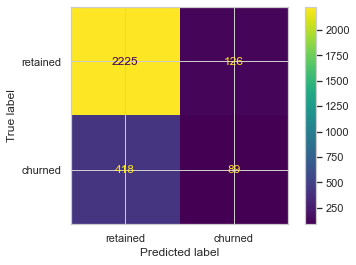

In [90]:
# Generate array of values for confusion matrix

cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot(values_format='');

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

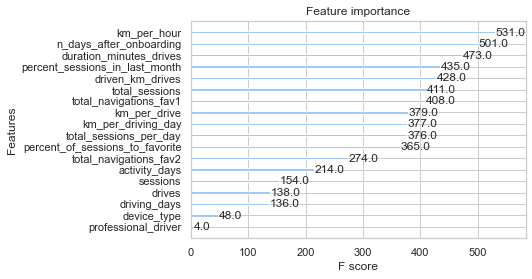

In [88]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.


### Reflect on these questions to complete the analysis:

**1. Would you recommend using this model for churn prediction? Why or why not?**
- It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value.


**2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?**
- Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data.


**3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?**
- Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction.


**4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?**
- Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with.



**5. What could you do to improve this model?**
- New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features.



**6. What additional features would you like to have to help improve the model?**
- It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.